# Zscores

In this notebook, we plot **Figures 4(a) and 4(b)**. To do so, we need to transform the ratings into zscore. Once again, we need to parse the ratings per year. 

*No requirement is needed to run this notebook.*

**Benchmark time**: This notebook has been run on a Dell Latitude (ElementaryOS 0.4.1 Loki, i7-7600U, 16GB RAM).

In [1]:
import os
os.chdir('..')

In [2]:
# Helpers functions
from python.helpers import parse

# Libraries for preparing data
import json
import gzip
import numpy as np
import pandas as pd
from datetime import datetime

# Libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib

# Folders
data_folder = '../data/'
fig_folder = '../figures/'

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# General info for plotting
colors = {'ba': (232/255,164/255,29/255), 
          'rb': (0/255,152/255,205/255)}

labels = {'ba': 'BeerAdvocate', 'rb': 'RateBeer'}

# Check that folders exist
if not os.path.exists(data_folder + 'tmp'):
    os.makedirs(data_folder + 'tmp')

if not os.path.exists(data_folder + 'prepared'):
    os.makedirs(data_folder + 'prepared')
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

## Get the ratings for the matched beers

In the next cell, we compute the ratings for the matched beers only. This is done in order to speed up the process a little bit.

In [3]:
%%time

# Load DF of matched beers
df = pd.read_csv(data_folder + 'matched/beers.csv', header=[0,1])
# Get the ids
beer_ids = {'ba': np.array(df['ba']['beer_id']), 'rb': np.array(df['rb']['beer_id'])}

# Go through BA and RB
for key in ['ba', 'rb']:
    print('Parse {} ratings'.format(key.upper()))
    
    # Get iterator
    gen = parse(data_folder + key + '/ratings.txt.gz'.format(key))
    
    # Open the new gzip file
    file_ = gzip.open(data_folder + 'matched/ratings_{}.txt.gz'.format(key), 'wb')

    # Go through iterator
    for item in gen:
        # Check if the beer corresponds to a matched beers
        if int(item['beer_id']) in beer_ids[key]:
            # If yes, add it to the new gzip file
            for key_dct in item.keys():
                file_.write('{}: {}\n'.format(key_dct, item[key_dct]).encode('utf-8'))
            file_.write('\n'.encode('utf-8'))
            
    file_.close()

Parse BA ratings
Parse RB ratings
CPU times: user 19min 26s, sys: 2.61 s, total: 19min 29s
Wall time: 19min 31s


In [4]:
%%time

# Get the ratings for every year for both BA and RB
ratings_year = {'ba': {}, 'rb': {}}

# Go through RB and BA
for key in ratings_year.keys():
    print('Parsing {} reviews.'.format(key.upper()))
    
    # Get the iterator
    gen = parse(data_folder + '/matched/ratings_{}.txt.gz'.format(key))
    
    # Go through the iterator
    for item in gen:
        
        # Get the data and then the year
        date = int(item['date'])
        year = datetime.fromtimestamp(date).year
                        
        if year not in ratings_year[key].keys():
            ratings_year[key][year] = []
        
        # Add the rating in the correct year
        ratings_year[key][year].append(float(item['rating']))
        
with open(data_folder + 'tmp/rating_per_year_matched.json', 'w') as outfile:
    json.dump(ratings_year, outfile)

Parsing BA reviews.
Parsing RB reviews.
CPU times: user 1min 33s, sys: 524 ms, total: 1min 33s
Wall time: 1min 34s


## Compute the zscores

First, we need to get the parameters for the zscores (mean and std). The zscore is defined as:

\begin{equation}
z = \frac{x - \bar{x}_y}{\sigma_y}
\end{equation}
where $x$ is the rating, $\bar{x}_y$ is the average rating for the year $y$, and $\sigma_y$ is the std for the year $y$. The year $y$ corresponds to the year in which the rating $x$ was given.

In [5]:
%%time

# Get the file rating_per_year from notebook 3
with open(data_folder + 'tmp/rating_per_year_matched.json', 'r') as infile:
    ratings_year = json.load(infile)

# Prepare the dict of mean and std per year to compute the zscore
z_score_params = {}

# Go through BA and RB
for key in ratings_year.keys():
    z_score_params[key] = {}
    # Go through each year
    for y in ratings_year[key].keys():
        # Add the average and STD
        z_score_params[key][y] = {'mean': np.mean(ratings_year[key][y]), 'std': np.std(ratings_year[key][y])}
        if z_score_params[key][y]['std'] == 0:
            z_score_params[key][y]['std'] = 1
            
# Fill some missing years
z_score_params['ba'][1996] = {'mean': 0, 'std': 1}
z_score_params['ba'][1997] = {'mean': 0, 'std': 1}

# And save the file
with open(data_folder + 'tmp/z_score_params_matched_ratings.json', 'w') as file:
    json.dump(z_score_params, file)

CPU times: user 444 ms, sys: 8 ms, total: 452 ms
Wall time: 450 ms


In [6]:
%%time

with open('../data/tmp/z_score_params_matched_ratings.json') as file:
    z_score_params = json.load(file)
    
# Prepare the dict with zscores for ba and rb
zscore = {'ba': [], 'rb': []}

# Beers zscore
beers_zscore = {}

# Go through BA and RB
for key in zscore.keys():
    
    beers_zscore[key] = {}
    
    print('Parsing {} reviews.'.format(key.upper()))
    
    # Get the iterator with the ratings fo the matched beers
    gen = parse(data_folder + 'matched/ratings_{}.txt.gz'.format(key))
    
    # Go through the iterator
    for item in gen:
        
        # Get the year
        date = int(item['date'])
        year = str(datetime.fromtimestamp(date).year)
        
        # Get the rating
        rat = float(item['rating'])
        
        # Compute its zscore based on the year
        zs = (rat-z_score_params[key][year]['mean'])/z_score_params[key][year]['std']
        zscore[key].append(zs)
        
        # get the beer id
        beer_id = int(item['beer_id'])
        
        # Add it to the dict if needed
        if beer_id not in beers_zscore[key].keys():
            beers_zscore[key][beer_id] = []
            
        # Add the zscore to the beer with corresponding id             
        beers_zscore[key][beer_id].append(zs)
        
# Save the file
with open(data_folder + 'prepared/zscore_matched.json', 'w') as outfile:
    json.dump(zscore, outfile)

Parsing BA reviews.
Parsing RB reviews.
CPU times: user 1min 38s, sys: 508 ms, total: 1min 38s
Wall time: 1min 38s


In [7]:
%%time

# Compute avg zscore for each beer
beers_avg_zscore = {}
for key in beers_zscore.keys():
    beers_avg_zscore[key] = {}
    for id_ in beers_zscore[key].keys():
        beers_avg_zscore[key][id_] = np.mean(beers_zscore[key][id_])

# Add the zscores to the matched beers
df = pd.read_csv(data_folder + 'matched/beers.csv', header=[0,1])

# Go through RB and BA
for key in ['ba', 'rb']:
    
    zscores = []
    nbr_ratings = []
    # Go through all matched beers
    for i in df.index:
        row = df.iloc[i][key]
        
        # Get the id
        beer_id = int(row['beer_id'])
        
        # append the avg zscore
        if beer_id not in beers_avg_zscore[key].keys():
            zscores.append(np.nan)
            nbr_ratings.append(0)
        else:
            zscores.append(beers_avg_zscore[key][beer_id])
            nbr_ratings.append(len(beers_zscore[key][beer_id]))
            
    # Add the column                
    df.loc[:, (key, 'zscore')] = zscores
    df.loc[:, (key, 'nbr_ratings')] = nbr_ratings

# Save again
df.to_csv(data_folder + 'matched/beers.csv', index=False)

CPU times: user 41.9 s, sys: 148 ms, total: 42.1 s
Wall time: 42.1 s


## Plot the zscores for the ratings of the matched beers

The next cell plots Figure 4(a).

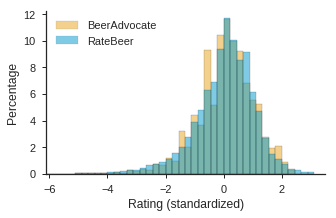

In [8]:
with open(data_folder + 'prepared/zscore_matched.json', 'r') as infile:
    zscore = json.load(infile)

years = list(range(2001, 2018))
x = np.array(range(len(years)))

plt.figure(figsize=(5, 3), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

nbr_bins = 45

bin_edges = {'ba': None, 'rb': None}
hist = {'ba': None, 'rb': None}

for key in bin_edges.keys():
    a, bin_edges[key] = np.histogram(zscore[key], range=(-7, 3), bins=nbr_bins)
    hist[key], a = np.histogram(zscore[key], range=(-7, 3), bins=nbr_bins+1)
    hist[key] = hist[key]/np.sum(hist[key])*100
    
for key in hist.keys():
    width = bin_edges[key][1] - bin_edges[key][0]
    plt.bar(bin_edges[key], hist[key], width = width, 
            facecolor=colors[key], edgecolor='grey', alpha=0.5, 
            label=labels[key])
    
plt.ylabel('Percentage')
plt.xlabel('Rating (standardized)')

plt.xlim([-6.1, 3.5])

leg = plt.legend()
leg.get_frame().set_linewidth(0.0)

plt.savefig(fig_folder + 'zscore_matched_beers.pdf', bbox_inches='tight')

# Hexagon plot

The next cell plots Figure 4(b).

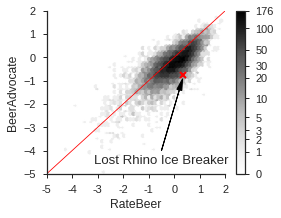

In [9]:
# Load files    
df = pd.read_csv(data_folder + 'matched/beers.csv', header=[0,1])

# params
min_nbr_ratings = 5
df = df[(df['ba']['nbr_ratings'] >= min_nbr_ratings) & (df['rb']['nbr_ratings'] >= min_nbr_ratings)]
df.index = range(len(df))

idx = df[df['ba']['beer_id'] == 78599].index[0]

ticks = [0, 1, 2, 3, 5, 10, 20, 30, 50, 100, 176]
log_ticks = []
for t in ticks:
    log_ticks.append(np.log10(t+1))
    
key = 'zscore'

plt.figure(figsize=(4, 3), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

hb = ax.hexbin(df['rb'][key], df['ba'][key], gridsize=50, bins='log', cmap='Greys')
ax.plot([-5, 2], [-5, 2], 'red', linewidth=0.8)

ax.axis([-5, 2, -5, 2])
plt.xticks(list(range(-5, 3)), list(range(-5, 3)))

plt.xlabel('RateBeer')
plt.ylabel('BeerAdvocate')

cb = plt.colorbar(hb, ax=ax, ticks=log_ticks)
cb.ax.set_yticklabels(ticks)
ax.set_facecolor('white')
row = df.loc[idx]
name = row['rb']['beer_name']
x = row['rb'][key]
y = row['ba'][key]

plt.plot([x], [y], 'x', color='r', mew=2, ms=6)

plt.arrow(-0.5, -4, x+0.35, 2.6, linewidth=1, head_width=0.2, head_length=0.5, fc='k', ec='k')

plt.text(-0.5, -4.7, name, horizontalalignment='center', verticalalignment='bottom')

plt.savefig(fig_folder + 'hexhist_zscores_example.pdf', bbox_inches='tight')